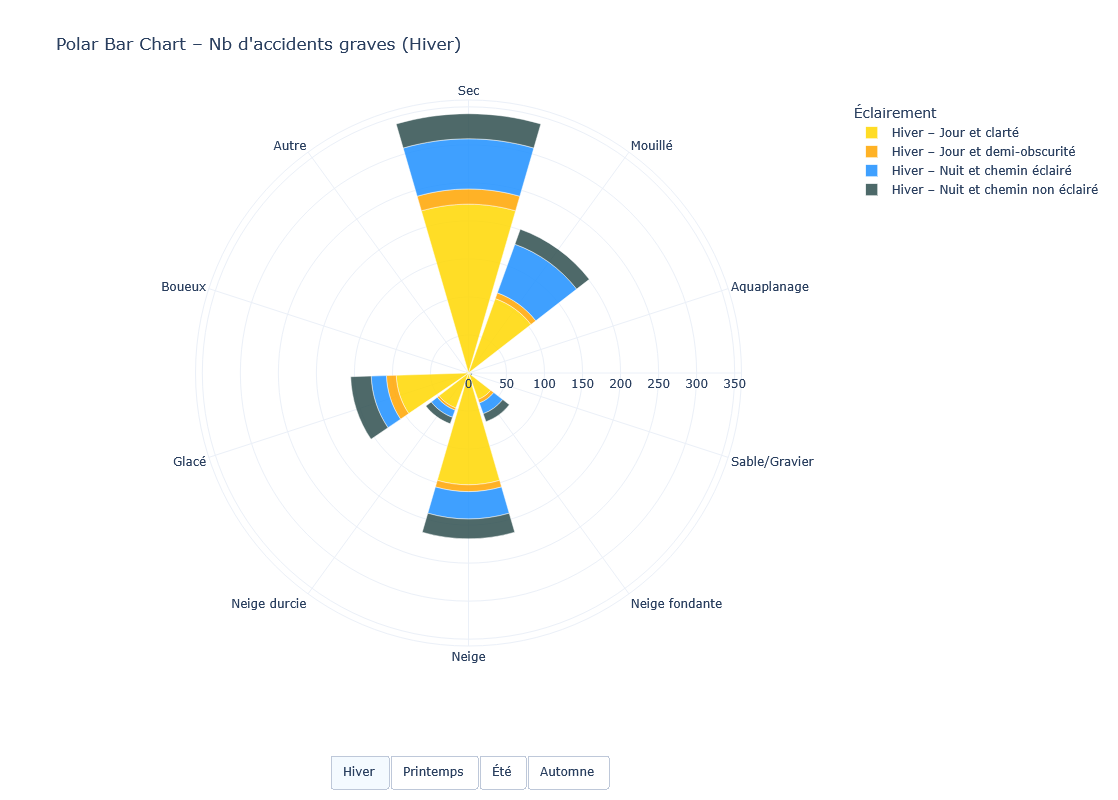

In [2]:
import plotly.graph_objects as go
import pandas as pd

# Étape 0 : Chargement et préparation des données
df = pd.read_csv('data_fusionnee.csv')

# Étape 1 : Création des saisons
df['MS_ACCDN'] = df['MS_ACCDN'].astype(int)

def mois_vers_saison(mois):
    if mois in [1, 2, 3]: return 'Hiver'
    elif mois in [4, 5, 6]: return 'Printemps'
    elif mois in [7, 8, 9]: return 'Été'
    elif mois in [10, 11, 12]: return 'Automne'

df['SAISON'] = df['MS_ACCDN'].apply(mois_vers_saison)

# Étape 2: Différenciation entre les accidents considérés comme Grave
df['Gravité'] = df['GRAVITE'].apply(lambda x: 'Grave' if x == 'Mortel ou grave' else 'Autre')

# Étape 3: Définition des types de surfaces
etat_surface_labels = [
    "Sec", "Mouillé", "Aquaplanage", "Sable/Gravier", "Neige fondante",
    "Neige", "Neige durcie", "Glacé", "Boueux", "Autre"
]

# Étape 4: Segmentation du disques par rapport au type de surface
etat_surface_codes = [11, 12, 13, 14, 15, 16, 17, 18, 19, 99]
theta = [i * (360 / len(etat_surface_codes)) for i in range(len(etat_surface_codes))]

# Étape 5: Choix des couleurs pour les éclairements
couleur_eclairement = {
    1: "#FFD700",
    2: "#FFA500",
    3: "#1E90FF",
    4: "#2F4F4F"
}

label_eclairement = {
    1: "Jour et clarté",
    2: "Jour et demi-obscurité",
    3: "Nuit et chemin éclairé",
    4: "Nuit et chemin non éclairé"
}

# Étape 6: Nettoyage au niveau de saison
saisons = df['SAISON'].dropna().unique().tolist()

# Étape 7: Conception de la figure
fig = go.Figure()
traces = []

# Dictionnaire des max par saison
max_par_saison = {}

for saison in saisons:
    saison_df = df[(df['SAISON'] == saison) & (df['Gravité'] == 'Grave')]

    # Calcul du total d'accidents graves par surface (tous éclairages confondus)
    total_par_surface = saison_df.groupby('CD_ETAT_SURFC').size()
    saison_max = total_par_surface.max()
    max_par_saison[saison] = saison_max + int(0.05 * saison_max)

    for eclairement in [1, 2, 3, 4]:
        subset = saison_df[saison_df['CD_ECLRM'] == eclairement]
        counts = subset.groupby('CD_ETAT_SURFC').size().reset_index(name='Nb Accidents Graves')

        r_vals = []
        hover_texts = []

        for code, label in zip(etat_surface_codes, etat_surface_labels):
            if code in counts['CD_ETAT_SURFC'].values:
                n_accidents = counts[counts['CD_ETAT_SURFC'] == code]['Nb Accidents Graves'].values[0]
            else:
                n_accidents = 0

            r_vals.append(n_accidents)
            hover_texts.append(
                f"Saison : {saison}<br>"
                f"Surface : {label}<br>"
                f"Éclairement : {label_eclairement[eclairement]}<br>"
                f"Accidents graves : {n_accidents}"
            )

        trace_visible = saison == saisons[0]

        fig.add_trace(go.Barpolar(
            r=r_vals,
            theta=theta,
            name=f'{saison} – {label_eclairement[eclairement]}',
            marker_color=couleur_eclairement[eclairement],
            opacity=0.85,
            visible=trace_visible,
            hovertext=hover_texts,
            hoverinfo='text'
        ))

        traces.append((saison, eclairement))

# Boutons avec mise à jour dynamique de l'échelle
buttons = []
for saison in saisons:
    visibility = [s == saison for s, e in traces]
    buttons.append(dict(
        label=saison,
        method="update",
        args=[
            {"visible": visibility},
            {
                "title": f"Polar Bar Chart – Nb d'accidents graves ({saison})",
                "polar.radialaxis.range": [0, max_par_saison[saison]]
            }
        ]
    ))

fig.update_layout(
    title=f"Polar Bar Chart – Nb d'accidents graves ({saisons[0]})",
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max_par_saison[saisons[0]]]
        ),
        angularaxis=dict(
            tickmode='array',
            tickvals=theta,
            ticktext=etat_surface_labels,
            rotation=90,
            direction="clockwise"
        )
    ),
    legend_title="Éclairement",
    template="plotly_white",
    width=900,
    height=800,
    margin=dict(l=100, r=100, t=100, b=150),
    updatemenus=[dict(
        type="buttons",
        direction="right",
        x=0.5,
        y=-0.2,
        xanchor="center",
        yanchor="top",
        showactive=True,
        buttons=buttons
    )]
)

fig.show()
